In [1]:
import torch
import torchvision
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import numpy as np
import torchvision.transforms as T
from torch.utils.data import sampler

In [2]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
device = torch.device("mps") if torch.mps.is_available() else torch.device("mps")
dtype = torch.float32

device

device(type='cpu')

In [3]:
transform = T.Compose([
                T.ToTensor(),
                T.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
            ])

inv_transform = T.Compose([
                T.Normalize((0., 0., 0.), (1/0.2023, 1/0.1994, 1/0.2010)),
                T.Normalize((-0.4914, -0.4822, -0.4465), (1., 1. ,1. )),
                T.ToPILImage()
            ])


NUM_TRAIN = 49000

ds_train = torchvision.datasets.CIFAR10('./', train=True, download=True, transform=transform)
ds_test  = torchvision.datasets.CIFAR10('./', train=False, download=True, transform=transform)

dl_train = DataLoader(ds_train, batch_size=64, sampler=sampler.SubsetRandomSampler(range(0, NUM_TRAIN)))
dl_valid = DataLoader(ds_train, batch_size=64, sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN, 50000)))
dl_test  = DataLoader(ds_test,  batch_size=64)

splits = {
    "train": dl_train,
    "valid": dl_valid,
    "test": dl_test,
}

Files already downloaded and verified
Files already downloaded and verified


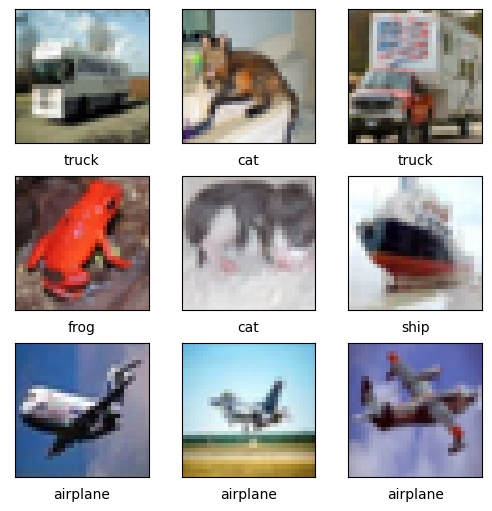

In [4]:
def plot_sample(xb, yb, pred=None):
    fig, axs = plt.subplots(3, 3, figsize=(5, 5), layout='constrained')

    for r in range(3):
        for c in range(3):
            ax = axs[r][c]
            x = xb[r*3 + c]
            y = yb[r*3 + c]
            x = inv_transform(x)
            ax.imshow(x)
            ax.set_xticks([])
            ax.set_yticks([])
            ax.set_xlabel(ds_train.classes[y])

            if pred != None:
                yh = pred[r*3 + c]
                ax.set_xlabel(ds_train.classes[yh])

                if yh != y:
                    ax.xaxis.label.set_color('r')

xb, yb = next(iter(dl_train))
plot_sample(xb, yb)

## Model

In [11]:
class CNN(nn.Module):

    def __init__(self):
        super().__init__()

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(32*32*32, 32*32)
        self.fc2 = nn.Linear(32*32, 10)

    def forward(self, x):

        y = self.conv1(x).relu()
        y = self.conv2(y).relu()
        y = self.flatten(y)
        y = self.fc1(y).relu()
        y = self.fc2(y)

        return y


model = CNN()
print(f"parameter count: {sum([p.numel() for p in model.parameters()]):,}")

parameter count: 33,575,850


## Sanity Check

Initial loss check

In [10]:
model = CNN()
xb, yb = next(iter(dl_train))
yh = model(xb)
loss = F.cross_entropy(yh, yb)
loss.backward()

print("chance:", -torch.tensor(1/10).log().item())
print("loss:", loss.item())

chance: 2.3025851249694824
loss: 2.307947874069214


Check if model has the capacity of overfit a small batch

In [19]:
model = CNN()

xb, yb = next(iter(dl_train))
y = model(xb)
optimizer = torch.optim.Adam(model.parameters())
xb, yb = next(iter(dl_train))

for i in range(1000):
    optimizer.zero_grad()
    yh = model(xb)
    loss = F.cross_entropy(yh, yb)
    loss.backward()
    optimizer.step()
    
    if i % 10 == 0:
        print(f"{loss.item():.4f}")

    if loss.item() < 1e-5:
        break

2.3023
0.0076
0.0001
0.0000
CPU times: user 19.5 s, sys: 2.92 s, total: 22.4 s
Wall time: 7.08 s


Activation distribution check

In [ ]:
plt.figure(figsize=(20, 4))
legends = []
for i, t in enumerate(model.h):
    print('layer %d: mean %+.2f, std %.2f, saturated: %.2f%%' % (i, t.mean(), t.std(), (t.abs() > 0.99).float().mean()*100))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i}')

plt.legend(legends);
plt.title('activation distribution');

In [ ]:
plt.figure(figsize=(20, 4))
legends = []
layers = [model.linear1, model.linear2, model.linear3, model.linear4]

for i, l in enumerate(layers):
    t = l.weight.grad
    print('layer %d: mean %+.2f, std %.2f, zero: %.2f%%' % (i, t.mean(), t.std(), (t.abs() < 0.0001).float().mean()*100))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i}')

plt.legend(legends);
plt.title('gradient distribution');

## Training

In [14]:
@torch.no_grad()
def eval_split(split, model, sample_size=None):
    dl = splits[split]

    num_correct = 0
    num_sample = 0
    lossi = []
    i = 0

    for xb, yb in dl:
        xb = xb.to(device=device, dtype=dtype)
        yb = yb.to(device=device, dtype=torch.int64)

        logits = model(xb)
        loss = F.cross_entropy(logits, yb)
        lossi.append(loss.item())

        _, idx = logits.max(1)
        num_correct += (yb == idx).sum()
        num_sample += len(yb)

        i += len(xb)
        if i >= sample_size:
            break;

    accuracy = float(num_correct) / num_sample
    loss = torch.tensor(lossi).mean().item()
    return loss, accuracy

In [16]:
@torch.no_grad()
def grad_ratio(param, lr):
    update = -lr * param.grad 
    return update.std() / param.std()

In [26]:
%%time

model = CNN()
model = model.to(device=device)

dl = splits["train"]
epoch = 1
i = 0
n = len(dl) * epoch

metrics = []
optimizer = torch.optim.AdamW(model.parameters())

for _ in range(epoch):
    for xb, yb in dl:
        xb = xb.to(device=device, dtype=dtype)
        yb = yb.to(device=device)
        optimizer.zero_grad()

        logits = model(xb)
        loss = torch.nn.functional.cross_entropy(logits, yb)
        loss.backward()
        
        if i % 10 == 0:
            tr_loss, tr_acc = eval_split("train", model, sample_size=1024)
            va_loss, va_acc = eval_split("valid", model, sample_size=1024)
            # update_ratio = [grad_ratio(p) for p in model.parameters() if p.dim() == 2]
            metrics.append((tr_loss, tr_acc, va_loss, va_acc))

            print(f"{i/n:.2f}: {tr_loss:.2f} {va_loss:.2f} {tr_acc:.2f} {va_acc:.2f}")

        i += 1
        optimizer.step()

        if i == 30:
            break

0.00: 2.30 2.30 0.09 0.12
0.01: 2.26 2.27 0.14 0.14
0.03: 2.22 2.22 0.16 0.16
CPU times: user 22.2 s, sys: 3.64 s, total: 25.8 s
Wall time: 9.67 s


In [ ]:
eval_split("train", model), eval_split("valid", model)

In [ ]:
# plot loss and accuracy, one on left and another on the right
tr_loss, va_acc = zip(*metrics)

plt.figure(figsize=(8, 3))

plt.subplot(1, 2, 1)
plt.plot(tr_loss, label="tr_loss")
plt.title("loss")

plt.subplot(1, 2, 2)
plt.plot(va_acc, "g")
plt.title("accuracy")

In [ ]:
# unpack an array update_ratio of tuple into a tuple of array
ur = list(zip(*update_ratio))
for i, r in enumerate(ur):
    plt.plot(np.log10(r), label=f"param {i}")

plt.legend()

In [ ]:
@torch.no_grad()
def predict(x):
    logits = model(x)
    prob = F.softmax(logits, dim=1)
    yh = torch.argmax(prob, dim=1)
    return yh

In [ ]:
xb, yb = next(iter(dl_valid))
pred = predict(xb)

plot_sample(xb, yb, pred)